In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

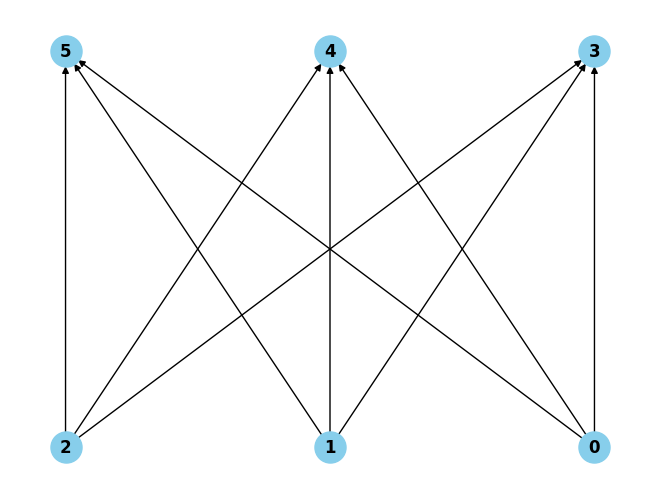

In [2]:
TR_INPUT = 3
TR_OUTPUT = 3
topology = create_stratified_topology([TR_INPUT,TR_OUTPUT])
NeuralNetwork.display_topology(topology)

In [3]:
topology

{0: ['input_0', None, [], [3, 4, 5]],
 1: ['input_0', None, [], [3, 4, 5]],
 2: ['input_0', None, [], [3, 4, 5]],
 3: ['output_1', 'identity', [], []],
 4: ['output_1', 'identity', [], []],
 5: ['output_1', 'identity', [], []]}

In [30]:
NN = NeuralNetwork(topology, -0.75, 0.75, True, RANDOM_STATE)

In [5]:
len_dataset = 1200
len_training = 1000
len_validation = 200
dummy = create_dataset(len_dataset, TR_INPUT, [-10, 10], 
                      [lambda x : -3*x[0] + x[1] + 3, # solo primi 2 input
                       lambda x : 3*x[0]**3 - 10*x[1]**2 + 2, # solo primi 2 input
                       lambda x : x[0] + x[1] + x[2] + 2], 
                      RANDOM_STATE)
tr_df = dummy[:len_training]
val_df = dummy[-len_validation:]
tr_df.sample(10, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3
144,-9.507814,-7.065543,7.989526,24.457899,-3075.696144,-6.583832
833,4.901076,3.983327,-0.217138,-7.719901,196.510629,10.667265
270,-4.355442,-7.950446,-2.506105,8.115881,-877.962613,-12.811994
468,5.651247,-8.446045,-4.519016,-22.399786,-169.912138,-5.313815
962,-6.966656,-2.704203,-6.671284,21.195766,-1085.492562,-14.342143
186,-1.838356,-6.304518,4.251111,2.210549,-414.107906,-1.891763
942,-2.711445,-3.392900,-6.262313,7.741434,-172.920793,-10.366658
516,-5.454023,5.195639,8.192003,24.557707,-754.658667,9.933619
286,-9.964158,3.738099,-5.053696,36.630572,-3105.591329,-9.279755
458,-9.266937,3.344150,-4.584328,34.144959,-2497.258832,-8.507115


In [6]:
scaler_out = MinMaxScaler()
scaler_in = MinMaxScaler()
scaler_in.fit(tr_df.values[:,:TR_INPUT])
scaler_out.fit(tr_df.values[:,TR_INPUT:])

tr_normalized = np.empty((len_training, TR_OUTPUT+TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(tr_df.values[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(tr_df.values[:,TR_INPUT:])

val_normalized = np.empty((len_validation, TR_OUTPUT+TR_INPUT))
val_normalized[:,:TR_INPUT] = scaler_in.transform(val_df.values[:,:TR_INPUT])
val_normalized[:,TR_INPUT:] = scaler_out.transform(val_df.values[:,TR_INPUT:])

In [7]:
tr_df_normalized = pd.DataFrame(data = tr_normalized, columns=tr_df.columns)
val_df_normalized = pd.DataFrame(data = val_normalized, columns=tr_df.columns)

In [8]:
training_set = tr_df.values
validation_set = val_df.values

batch_size = 100
max_epochs = 1000
error_decrease_tolerance = 0.0001
patience = 5

learning_rate = 0.01/batch_size
lambda_tikhonov = 0
alpha_momentum = 0

stats = NN.train(tr_normalized, val_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, 
                   learning_rate, lambda_tikhonov, alpha_momentum)

In [9]:
tr_predictions_normalized = NN.predict_array(tr_normalized[:,:TR_INPUT])
tr_predictions = scaler_out.inverse_transform(tr_predictions_normalized)

In [10]:
pd.options.mode.chained_assignment = None
tr_df[['prediction_1', 'prediction_2', 'prediction_3']] = tr_predictions
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    tr_df[['prediction_1', 'prediction_2', 'prediction_3']] = tr_predictions


tr_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = tr_predictions_normalized
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    tr_df_normalized[col + '_err'] = (tr_df_normalized[col] - tr_df_normalized['output_' + col[-1]])**2
    tr_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = tr_predictions_normalized

In [11]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3,prediction_1,prediction_2,prediction_3,prediction_1_err,prediction_2_err,prediction_3_err
144,-9.507814,-7.065543,7.989526,24.457899,-3075.696144,-6.583832,23.957911,-2049.471568,-6.608313,0.249988,1.053137e+06,0.000599
833,4.901076,3.983327,-0.217138,-7.719901,196.510629,10.667265,-7.326708,533.682094,10.659120,0.154601,1.136846e+05,0.000066
270,-4.355442,-7.950446,-2.506105,8.115881,-877.962613,-12.811994,7.281688,-1116.401138,-12.782421,0.695877,5.685293e+04,0.000875
468,5.651247,-8.446045,-4.519016,-22.399786,-169.912138,-5.313815,-22.704157,653.336001,-5.298029,0.092642,6.777375e+05,0.000249
962,-6.966656,-2.704203,-6.671284,21.195766,-1085.492562,-14.342143,20.133345,-1557.246964,-14.277810,1.128738,2.225522e+05,0.004139


In [12]:
val_predictions_normalized = NN.predict_array(val_normalized[:,:TR_INPUT])
val_predictions = scaler_out.inverse_transform(val_predictions_normalized)

In [13]:
val_df[['prediction_1', 'prediction_2', 'prediction_3']] = val_predictions
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2
    val_df[['prediction_1', 'prediction_2', 'prediction_3']] = val_predictions

val_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = val_predictions_normalized
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    val_df_normalized[col + '_err'] = (val_df_normalized[col] - val_df_normalized['output_' + col[-1]])**2
    val_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = val_predictions_normalized

In [14]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3,prediction_1,prediction_2,prediction_3,prediction_1_err,prediction_2_err,prediction_3_err
1052,7.274040,-8.058143,5.358667,-26.880263,507.307953,6.574565,-26.452107,916.376045,6.522112,0.183318,167336.703943,0.002751
1157,-8.370484,2.360876,5.707484,30.472329,-1813.171449,1.697876,30.274680,-1825.639897,1.686588,0.039065,155.462183,0.000127
1135,5.037616,7.890774,8.698532,-4.222075,-237.115635,23.626922,-3.118769,543.368091,23.561284,1.217285,609154.846842,0.004308
1140,-7.095906,-2.108666,-5.960705,22.179053,-1114.341529,-13.165278,21.174845,-1580.672393,-13.105108,1.008433,217464.474811,0.003620
1056,-3.930807,8.685863,1.046533,23.478285,-934.649762,7.801588,23.538044,-1019.078604,7.809592,0.003571,7128.229324,0.000064


In [15]:
for key in list(stats.keys())[:9]:
    print(key, ':', stats[key])

training_set_len : 1000
minibatch_size : 100
max_epochs : 1000
error_decrease_tolerance : 0.0001
patience : 5
learning_rate : 0.0001
lambda_tikhonov : 0
alpha_momentum : 0
epochs : 723


In [16]:
print('last training errors')
print(stats['training_error'][-5:])

last training errors
[0.006142287056074458, 0.006141687236517459, 0.0061410932738031315, 0.006140505109464386, 0.006139922685637949]


In [17]:
print('last validation errors')
print(stats['validation_error'][-5:])

last validation errors
[0.005171610941698174, 0.005171226688522063, 0.005170846888830842, 0.005170471494349162, 0.005170100457324006]


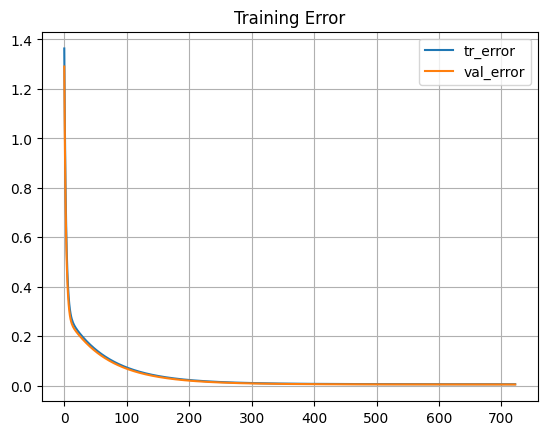

In [18]:
multy_plot([stats['training_error'], stats['validation_error']], ['tr_error', 'val_error'], 'Training Error')

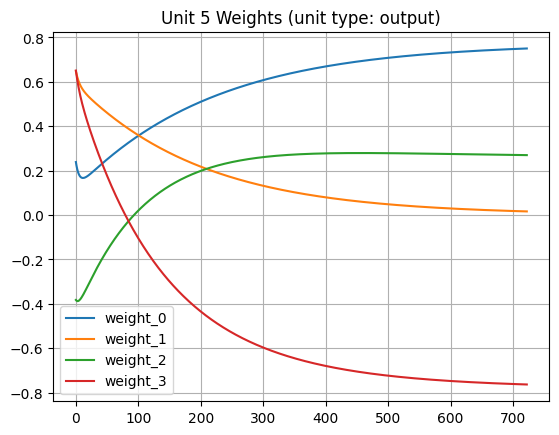

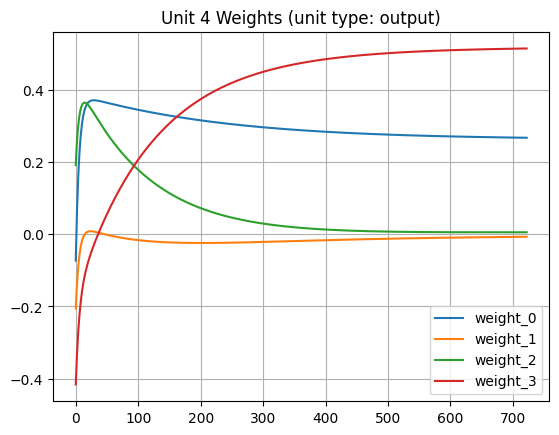

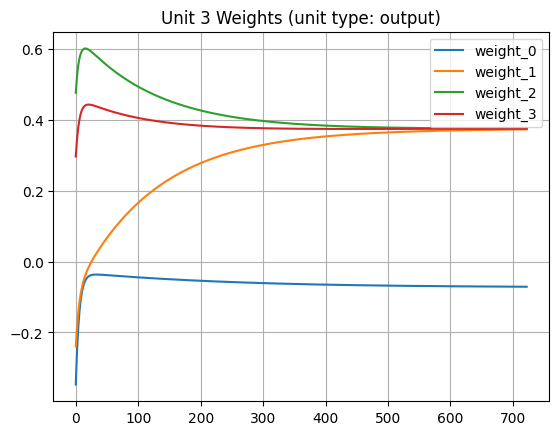

In [19]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

In [20]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3,prediction_1,prediction_2,prediction_3,prediction_1_err,prediction_2_err,prediction_3_err
144,-9.507814,-7.065543,7.989526,24.457899,-3075.696144,-6.583832,23.957911,-2049.471568,-6.608313,0.249988,1.053137e+06,0.000599
833,4.901076,3.983327,-0.217138,-7.719901,196.510629,10.667265,-7.326708,533.682094,10.659120,0.154601,1.136846e+05,0.000066
270,-4.355442,-7.950446,-2.506105,8.115881,-877.962613,-12.811994,7.281688,-1116.401138,-12.782421,0.695877,5.685293e+04,0.000875
468,5.651247,-8.446045,-4.519016,-22.399786,-169.912138,-5.313815,-22.704157,653.336001,-5.298029,0.092642,6.777375e+05,0.000249
962,-6.966656,-2.704203,-6.671284,21.195766,-1085.492562,-14.342143,20.133345,-1557.246964,-14.277810,1.128738,2.225522e+05,0.004139


In [21]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3,prediction_1,prediction_2,prediction_3,prediction_1_err,prediction_2_err,prediction_3_err
1052,7.274040,-8.058143,5.358667,-26.880263,507.307953,6.574565,-26.452107,916.376045,6.522112,0.183318,167336.703943,0.002751
1157,-8.370484,2.360876,5.707484,30.472329,-1813.171449,1.697876,30.274680,-1825.639897,1.686588,0.039065,155.462183,0.000127
1135,5.037616,7.890774,8.698532,-4.222075,-237.115635,23.626922,-3.118769,543.368091,23.561284,1.217285,609154.846842,0.004308
1140,-7.095906,-2.108666,-5.960705,22.179053,-1114.341529,-13.165278,21.174845,-1580.672393,-13.105108,1.008433,217464.474811,0.003620
1056,-3.930807,8.685863,1.046533,23.478285,-934.649762,7.801588,23.538044,-1019.078604,7.809592,0.003571,7128.229324,0.000064


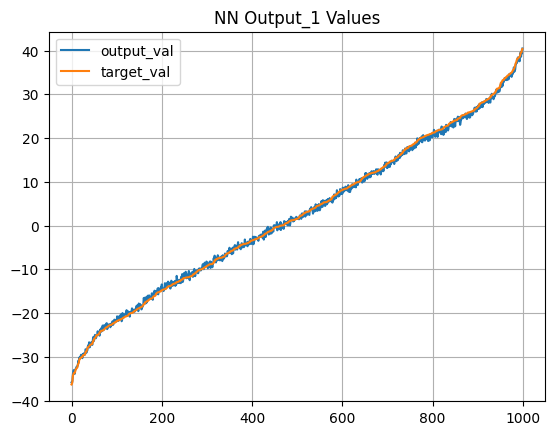

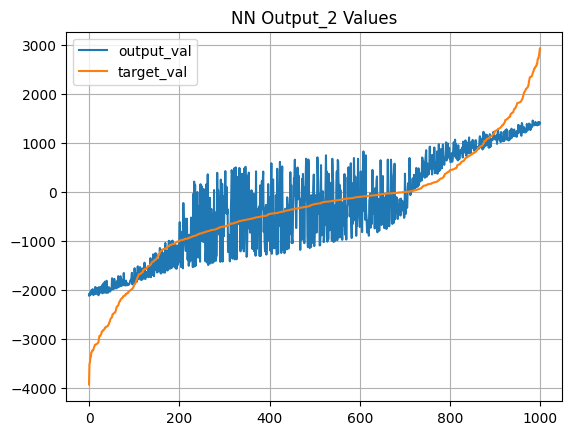

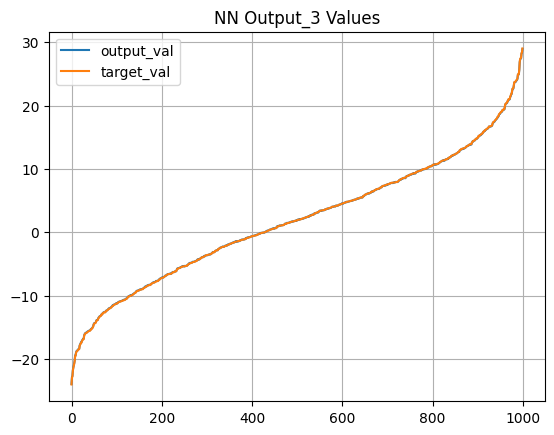

In [22]:
for i in range(TR_INPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_predictions[sorted_order][:,i] , training_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

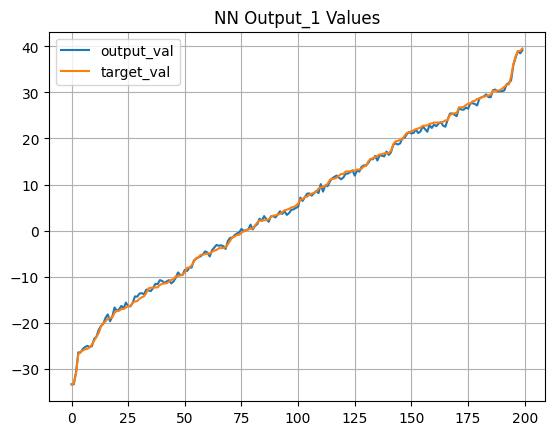

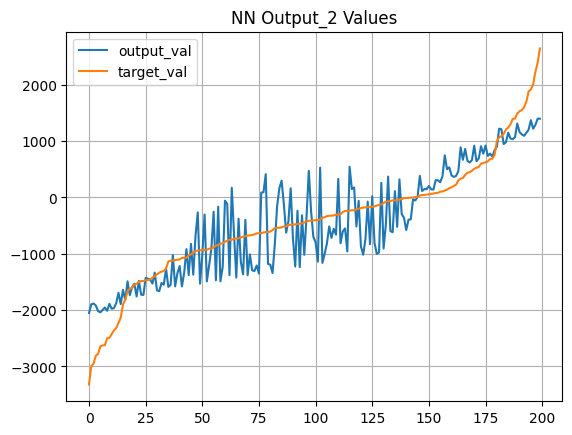

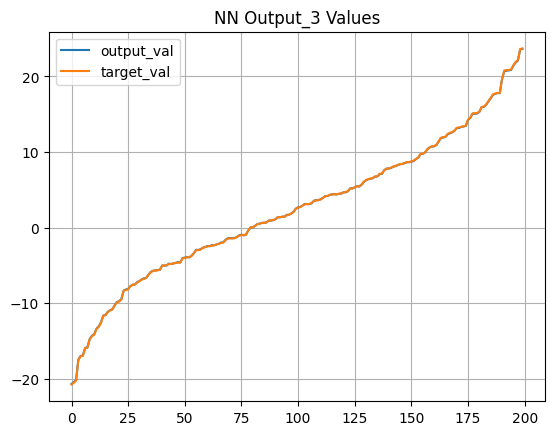

In [23]:
for i in range(TR_INPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_predictions[sorted_order][:,i] , validation_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

Tot points: 1000


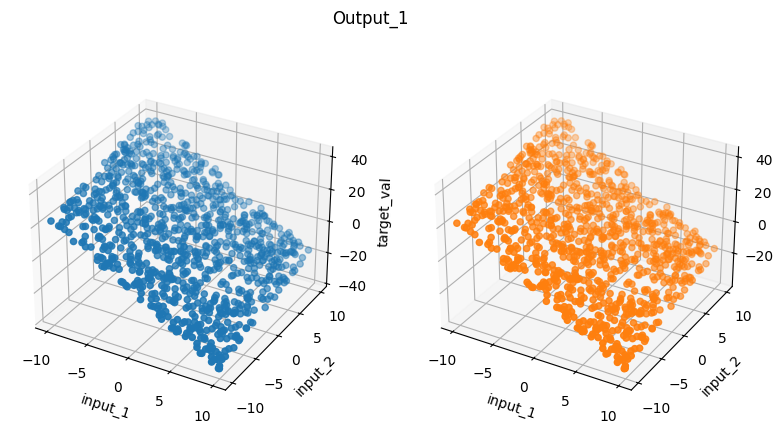

In [24]:
multy_plot_3d([training_set[:,0], training_set[:,0]], 
              [training_set[:,1], training_set[:,1]],
              [training_set[:,TR_INPUT], tr_predictions[:,0]],
              [['input_1', 'input_2', 'target_val'], ['input_1', 'input_2', 'output_val']],
              'Output_1');

Tot points: 1000


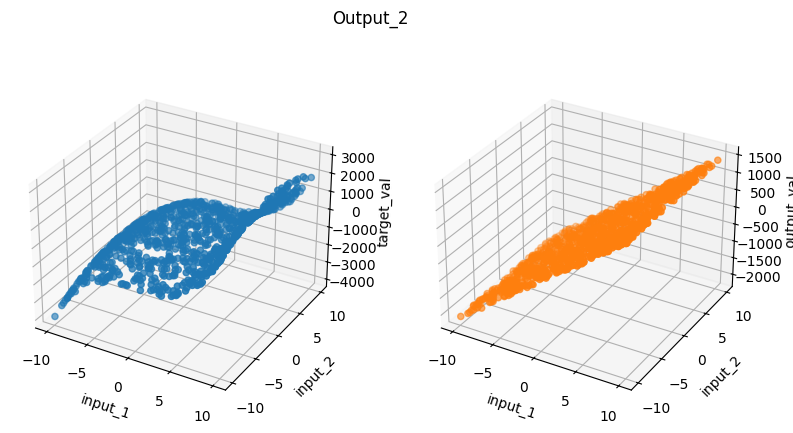

In [25]:
multy_plot_3d([training_set[:,0], training_set[:,0]], 
              [training_set[:,1], training_set[:,1]],
              [training_set[:,TR_INPUT + 1], tr_predictions[:,1]],
              [['input_1', 'input_2', 'target_val'], ['input_1', 'input_2', 'output_val']],
              'Output_2');

In [26]:
interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'prediction_2', 'prediction_2_err')

Tot points: 1000


In [27]:
interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'output_2', 'prediction_2_err')

Tot points: 1000


In [28]:
interactive_3d_plot(val_df_normalized, 'input_1', 'input_2', 'prediction_2', 'prediction_2_err')

Tot points: 200


In [29]:
interactive_3d_plot(val_df_normalized, 'input_1', 'input_2', 'output_2', 'prediction_2_err')

Tot points: 200
